<h1>Отчет</h1>

<p>Подключим необходимые библиотеки.</p>

In [8]:
from math import *
from scipy import special
import numpy as np
import cmath
import time
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Image, SVG, Math, YouTubeVideo
import matplotlib.pyplot as plt

<p>Определим функцию $sinc(x)$.</p>

In [9]:
def sinc(x):
    '''
    Compute the sinc-function: sin(x) / x
    '''
    try:  
        return sin(x) / x
    except ZeroDivisionError:
        return 1.

<h2>Поставим теперь задачу:</h2>
<p>Требуется реализовать программу, результатом работы которой мы бы получили два набора функций, один из которых представлял бы из себя набор сферических функции Бесселя от нулевого до порядка, который передавается в программу в виде параметра (назовем его $N_{max}$), а другой - массив сферических функций Неймана тех же порядков.</p>
<p>Сферические функции Бесселя и Неймана и их производные могут быть рассчитаны по известным рекуррентным соотношениям:
</p>

$$s_n(\zeta) = \frac{2n - 1}{\zeta}s_{n-1}(\zeta)-s_{n-2}(\zeta) \tag{A1}$$

$$s_n^{'}(\zeta) = s_{n-1}(\zeta)-\frac{n + 1}{\zeta}s_{n}(\zeta) \tag{A2}$$

<p>где $s_n(\zeta)$ - условное обозначение одного из видов сферических функций, $\zeta$ - аргумент соответствующей функции.</p>
<p>Рекуррентная процедура $(А1)$ использует известные выражения для функций 0-го и 1-го порядков:</p>
$$j_0(\zeta)=\frac{sin\zeta}{\zeta},$$

$$j_1(\zeta)=-j_0^{'}(\zeta)=-\frac{cos\zeta}{\zeta}+\frac{sin\zeta}{\zeta^2},$$

$$y_0(\zeta)=-\frac{cos\zeta}{\zeta},$$

$$y_1(\zeta)=-y_0^{'}(\zeta)=-\frac{sin\zeta}{\zeta}-\frac{cos\zeta}{\zeta^2}.$$

<p>Но есть маленький нюанс. Процедура $(А1)$ является устойчивой для функций Неймана любых порядков и функций Бесселя порядков $n \leq \zeta$. Функции Бесселя порядков $n \geq \zeta$ находятся с помощью обратных рекуррентных соотношений:</p>

$$j_n(\zeta) = \frac{2n+3}{\zeta}j_{n+1}(\zeta)-j_{n+2}(\zeta) \tag{A3}$$

<p>Для запуска процедуры $(А3)$ с некоторого номера $N$ необходимо иметь значения функци $j_{N+2}(\zeta)$ и $j_{N+1}(\zeta)$, которые заранее неизвестны.  Однако рекуррентный алгоритм $(А3)$ довольно быстро выходит на ветвь, соответствующую функциям Бесселя, т.е. конкретные значения стартовых функций  и  не важны. Например, их можно выбрать равными 0 и 1 соответственно, а сам номер $N$ выбрать существенно, на несколько сотен, превышающим наибольшее из требуемых значений номера $n$. Рекуррентная процедура $(А3)$ при этом определяет функции Бесселя с точностью до некоторого неизвестного множителя: $\tilde{j_n}(\zeta) = \chi j_n(\zeta)$.</p>
<p>С уменьшением номера $n$ значения функций  чрезвычайно быстро нарастают и, вообще говоря, могут приблизиться к величине компьютерной бесконечности.  Поэтому целесообразно при некоторых значениях номера проводить их перенормировку.</p>

<h3>Реализация функции $\textit{upperRecurency}$</h3>
<p>Как было отмечено выше, на вход в программу передается целочисленное число $N_{max}$ - тот порядок, до которого будем рассчитывать сферические функции, и значение аргумента всех рассчитываемых функций, назовем его $\text{value}$.</p>
<p>Учтем, что порядки функций лежат в диапазоне от нуля до $N_{max}$, поэтому общее количество расчитываемых функций будет равно $N_{max} + 1$</p>
<ul>Создадим три одномерных массива размерностью $N_{max} + 1$ и заполним их нулями:
    <li>Массив сферических функций Бесселя --> $sphj$(spherical j)</li>
    <li>Массив сферических функций Неймана --> $sphy$(spherical y)</li> 
    <li>В силу неустойчивости алгоритма $(А1)$ будем использовать массив $\textit{new_sphj}$ для новых сферических функций Бесселя, получаемых путем использования алгоритма $(А3)$.</li>
</ul>
<p>Проверим на ненулевое значение аргумента, для избежания ошибки деления на ноль, при заполнении нулевых и первых порядков, которые известны нам точно. Если же пользователь хочет получить все сферические функции с аргументом равным нулю, то для инициализации первых и нулевых порядков обратимся к встроенным функциям, в которых предусмотрен случай деления на ноль и используются ассимптотические соотношения при стремлении аргумента функций к нулю.</p>
<p>Используем процедуру $(А1)$ для всех сферических функций Неймана требуемых порядков, и для той части сферических функций Бесселя, чей порядок меньше либо равен значению аргумента. Результатом получаем полностью готовый массив для сферических функций Неймана, и, в общем случае, неполностью заполненный массив сферических функций Бесселя.</p>
<p>Для следующей части сферических функций Бесселя, используем процедуру $(А3)$, для этого, согласно теории, описанной выше, уходим на пятьсот порядков выше, заполняем $N_{max}+500$ и $N_{max}+499$ порядки функций нулем и единицей соотвественно.</p>
<p>В процессе расчета, следим за численными значениями функций. В тот момент, когда модуль значения расчитанной функции превысил значение $100$, проверяем порядок этой функции. Пусть порядок функции, значение модуля которой превысило значение $100$, равен $n$.</p>
<ul>Возможны два случая:</ul>
<li>Если $n$ находится в диапазоне от $N_{max}$ до $N_{max} + 500$, то для оптимизации нам достаточно нормировать только $n$ и $n+1$ порядки функций делением на $100$, чтобы спускаться по индексам к требуемым порядкам, не теряя линейной связи с реальными сферическими функциями Бесселя.</li>
<li>Если же $n$ находится в диапазоне требуемых расчетных порядков, тогда требуется нормировать уже от $n$ до $N_{max}$, поэтому обратно направленным циклом производим перенормировку делением на $100$.</li>
<p>Уточним здесь то, что в процессе расчета этих функций, мы можем множество раз заходить в процесс перенормировки, таким образом, число обратных рекуррентных ходов может быть большим.</p>
<p>Результатом имеем полный набор новых сферических функций Бесселя требуемых порядков с точностью до неизвестного множителя.</p>

<p>Отметим одну особенность сферических функций Бесселя. В окрестности точки $z = n$ все три функции $j_{n-1}$, $j_n$, $j_{n+1}$ растущие, причем примерно равные своему максимальному значению (см. рис. ниже), поэтому при сравнении функции $j_{Nz}(z)$, где $Nz = [z]$ ([$\cdot$] - целая часть), найденной из прямой (растущей) рекуррентной последовательности, с функцией $\text{new_j}_{Nz}=C\cdot j_{Nz}(z)$, найденной из обратной рекуррентной последовательности ($C$ - искомый неизвестный коэффициент), не будет проблем с малостью функций. Более того, эти сравниваемые функции будут по величине всего примерно в 2 раза меньше своих самых больших значений.</p>

<img src='https://bit.ly/35N2byp'>

In [10]:
def upperRecurency(value, Nmax):
    
    # Nmax is the larger index of requirement functions but quantity 
    # of required functions is (Nmax + 1) cause 0-index is included
    
    # Initialization the zero-arrays for calculating the functions
    sphj, sphy, new_sphj = np.zeros(Nmax + 1), np.zeros(Nmax + 1), np.zeros(Nmax + 501)
    
    # Check for non-zero value
    if value:
        
        # Compute the spherical Bessels functions of the first kind of zero 
        # and first-indexes in the current value
        sphj[0] = sinc(value)                                           # n = 0
        sphj[1] = (-1) * cos(value) / value + sin(value) / (value ** 2) # n = 1
        
        # Compute the spherical Bessels functions of the second kind of zero
        # and first-indexes in the current value
        sphy[0] = (-1) * cos(value) / value                             # n = 0
        sphy[1] = (-1) * sin(value) / value - cos(value) / (value ** 2) # n = 1  
        
    
    else:
        # "value == 0" case
        sphj[0] = special.spherical_jn(0, value)
        sphj[1] = special.spherical_jn(1, value)
        
        sphy[0] = special.spherical_yn(0, value)
        sphy[1] = special.spherical_yn(1, value)
        
    # Compute the spherical Bessels functions of the second kind another indexes
    # with bottom-to-top recurrency relation
    for ind in range(2, Nmax + 1):
        sphy[ind] = (2 * ind - 1) / value * sphy[ind - 1] - sphy[ind - 2]

    Nz = trunc(value) if value > 1 else 5
    if (Nz >= Nmax):
        for ind in range(2, Nmax + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]
        return (sphj, sphy)
    
    if (Nz < Nmax):
            
        # For another kind of spherical Bessels functions the previous algorithm isn't stable
        # and we calculate only the part of necessary functions
        for ind in range(2, Nz + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]


        # For another part we should use the top-to-bottom recurrency relation

        # Initialization {Nmax + 500} and {Nmax + 499}-indexes for this relation.
        # We should extend our quantity of calculating functions by 500
        # After that our 'new' spherical Bessels functions of the first kind will be known,
        # but it will be the real functions multiplied by the some const.
        new_sphj[Nmax + 500] = 0 # n = Nmax + 500
        new_sphj[Nmax + 499] = 1 # n = Nmax + 499

        # Calculate the 'new' spherical Bessels functions of the first kind of {98 + Nmax} down to {0} - indexes
        for ind in range(498 + Nmax, Nz - 1, -1):
            new_sphj[ind] = (2 * ind + 3) / value * new_sphj[ind + 1] - new_sphj[ind + 2]

            # We shouldn't forget about the fact that our 'new' functions dramatically increases step-by-step.
            # To avoid overflowing, we reduce all of the previous calculating functions by division on max in the array
            if abs(new_sphj[ind]) > 100:
                Max = np.max(new_sphj)

                # We don't care about indexes which we don't want to compute
                if ind <= Nmax:
                    for index in range(ind, Nmax + 1):
                        new_sphj[index] /= Max

                # For this case we should reduce only the {current index + 1} and {current index} functions
                # to continue our calculation
                else:
                    new_sphj[ind + 1] /= Max
                    new_sphj[ind] /= Max
                    
        # After all calculations we want to know the const of relation between the 'new'
        # and known Bessels functions of the first kind
        k = new_sphj[Nz] / sphj[Nz]

        # Initialize the new array for recalculation our 'new' Bessels functions with known constant
        bessels = []
        
        for elem in sphj:
            if elem != 0:
                bessels.append(elem)

        # Division all the 'new' functions by known constant
        for ind in range(Nz + 1, len(new_sphj[:Nmax + 1])):
#             if new_sphj[ind] != 0:
            bessels.append(new_sphj[ind] / k)

        # After all kinds of calculations, we return the 1st and 2nd kind of functions as 2 arrays in the current value
        return bessels, sphy

<p>Определим теперь функцию $\textit{derivative}$, которая будет получать на вход набор уже известных нам сферических функций Неймана и Бесселя, и их аргумент. Далее реализуем процедуру $(A2)$, для этого инициализируем начальные значения и производим рекуррентный расчет. Результатом функции является кортеж одномерных массивов производных от сферических функций Бесселя и Неймана с аргументом, переданным в эту функцию. </p>

In [11]:
def derivative(sphj, sphy, value):
    # Initialization the zero-arrays for calculating the derivative functions
    sphj_der, sphy_der = np.zeros(len(sphj)), np.zeros(len(sphy))
    
    # Define ititial derivatives
    sphj_der[0] = cos(value) / value - sin(value) / (value ** 2)
    sphy_der[0] = sin(value) / value + cos(value) / (value ** 2)
    
    # Compute another indexes with recurrency relation for derivatives
    for ind in range(1, len(sphy)):
        sphj_der[ind] = sphj[ind - 1] - (ind + 1) / value * sphj[ind]
        sphy_der[ind] = sphy[ind - 1] - (ind + 1) / value * sphy[ind]
    return sphj_der, sphy_der

In [12]:
# Square root + theorem of cos
def sqrthcos(r, z0, costheta):
    return (r ** 2 + z0 ** 2 + 2 * r * z0 * costheta) ** .5

# Initialize the parameters of required functions
# Nmax -> quantity of required functions
# z0 -> initial coordinate of the spherical-wave sourse
# step -> cells-step
Nmax = 30
z0 = 50
step = 1
a = 5 * (10 ** (-3))  # 5mm radius of sperical object
f = 10 ** 6  # 1 MHz
k = 2 * pi * f / 1500  # k = w / c, w = 2piv
# k = 1
p_0 = 1
A_sp = 1
rho = 1000
c_sound = 1500 #1485 m/s


# Initialize the matrix 401 x 401 ([-200, 200] x [-200, 200]) with complex data type for theoretical functions
p_ith = np.zeros((401, 401), dtype=complex)
p_spth = np.zeros((401, 401), dtype=complex)
p_sc = np.zeros((401, 401), dtype=complex)
p_sc_sp = np.zeros((401, 401), dtype=complex)


# Initialize the matrix 1 x Nmax for Legendre Polynomials
P = np.zeros(Nmax + 1)

# Initialize the matrix 401 x 401 ([-200, 200] x [-200, 200]) with complex data type for calculating functions
p_i = np.zeros((401, 401), dtype=complex)
p_sp = np.zeros((401, 401), dtype=complex)

# Calculating the Bessels functions with the help of our function called as 'upperRecurency' in the value k*z0
sphjz0, sphyz0 = upperRecurency(k * z0, Nmax)

t = time.time()
e = np.zeros((401, 401), dtype=float)
e_sp = np.zeros((401, 401), dtype=float)

In [13]:
def Q_sp(n, sphjz0, sphyz0):
    return A_sp * 1j * k * ((-1) ** n) * (2 * n + 1) * (sphjz0[n] + 1j * sphyz0[n])

def Q_pl(n):
    return p_0 * (1j ** n) * (2 * n + 1)

<p>Радиационная сила, точнее ее проекция на ось $z$, может быть представлена как:</p>

$$F_z = \frac{2\pi}{\rho c^2 k^2}\sum_{n=0}^{\infty}\frac{(n+1)}{(2n+1)(2n+3)}Im[Q_nQ_{n+1}^*(c_n+c_{n+1}^*+2c_nc_{n+1}^*)]\tag{1.17}$$

$$F_z^{(plane)}=-\frac{2\pi|p_0|^2}{\rho c^2 k^2}\sum_{n=0}^{\infty}(n+1)Re\{c_n+c_{n+1}^*+2c_nc_{n+1}^*\}$$

In [14]:
# calculate the coefficients in the sum for spherical wave
c = np.zeros(Nmax + 1, dtype=complex)
F_z_plane, F_z_spherical, Y_plane, Y_spherical = 0, 0, 0, 0

sphja, sphya = upperRecurency(k * a, Nmax)
sphja_der, sphya_der = derivative(sphja, sphya, k * a)

for n in range(len(sphya)):
    c[n] = -(sphja_der[n] / (sphja_der[n] + 1j * sphya_der[n])) 


for n in range(Nmax):
    F_z_spherical += 2 * pi / (rho * (c_sound ** 2) * (k ** 2)) *(n + 1) / ((2 * n + 1) * (2 * n + 3)) * np.imag(Q_sp(n, sphjz0, sphyz0) * np.conj(Q_sp(n + 1, sphjz0, sphyz0)) * (c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1])))
    F_z_plane += -2 * pi * (abs(p_0) ** 2) / (rho * (c_sound ** 2) * (k ** 2)) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))
    Y_plane += -4 * c_sound / (k * a) ** 2 * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))

<p>Поставим теперь задачу найти удельную радиационную силу в зависимости от частоты падающего излучения</p>
<p>Для этого введем вспомогательную нормировочную функцию, которая возвращает входной массив, но уже нормированный на свое максимальное значение</p>

In [15]:
def norm(lst):
    ans = []
    Umax = np.max(lst)
    for elem in lst:
        ans.append(elem / Umax)
    return ans

<p>Пусть частоты изменяются от 0.25 МГц до 2.5МГц с шагом в 0.001 МГц</p>
<p>Выберем радиус рассеивателя в 1мм</p>

<p>В случае абсолютно жесткого рассеивателя, коэффициенты разложения рассеянного поля найдем как раньше, для этого воспользуемся написанными ранее функциями, получим сферические функции и их производные, и по известному соотношению рассчитаем эти коэффициенты</p>

<p>Так как радиационная сила, действующая на рассеиватель, пропорциональна интенсивности падающей волны, то для удобства анализа в расчетах введем безразмерную величину удельной радиационной силы $Y_p$, индекс $p$ в обозначении помечает тот факт, что рассматривается падение плоской волны</p>

$$Y_p = \frac{F_z c}{I\pi a^2}, \text{ где } I =  \frac{p_0^2}{2\rho c^2}$$

$$Y_p = -\frac{4c_0}{(ka)^2}\sum_{n=0}^{\infty}(n+1)Re\{c_n + c_{n+1}^* + 2c_nc_{n+1}^*\}$$

In [47]:
f_array = np.arange(0.1, 8, 0.001)
# f_max = 69MHz
a = 1 * 10 ** (-3)
Y_plane_array = np.zeros(len(f_array))
# k - MHz -> 10^6 Hz, a - mm -> 10^-3 m => ka -> 10^3
c_sound = 1485
for ind in range(len(f_array)):
    k = 2 * pi * f_array[ind] * 10**6 / c_sound
    Nmax = trunc(3 * k * a)
    
    c = np.zeros(Nmax + 1, dtype=complex)
    
    sphja, sphya = upperRecurency(k * a, Nmax)
    sphja_der, sphya_der = derivative(sphja, sphya, k * a)
    
    for n in range(len(sphya)):
        c[n] =  (-1) * sphja_der[n] / (sphja_der[n] + 1j * sphya_der[n]) 

    for n in range(Nmax):
        Y_plane_array[ind] += (-4) * c_sound / ((k * a) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  

Y_plane_array_norm = norm(Y_plane_array)

<p>Изобразим полученный график для абсолютно жесткого рассеивателя с радиусом a = 1мм</p>

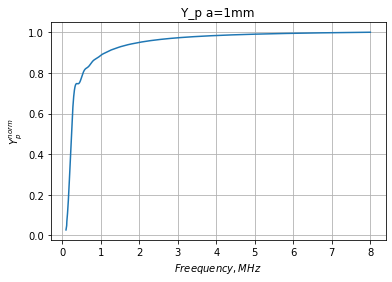

In [36]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$Freequency, MHz$')

plt.plot(f_array, Y_plane_array_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('Y_p a=1mm')
plt.show()

<p>Для случая не абсолютно жесткого рассеивателя, требуется учитывать упругие характеристики тела, поэтому введем вспомогательные функции</p>

<p>Вторая производная функции Бесселя находится из уравнения определяющие функции Бесселя через сами функции и их производные</p>

$$\frac{d^2j_n(x)}{dx^2} = -\frac{2}{x}j_n^{'}(x) - (1 - \frac{n(n+1)}{x})j_n(x)$$

In [37]:
def second_derivative(sphj, sphj_der, value, n):
    return  (-2) / value * sphj_der - (1 - n * (n + 1) / value ** 2) * sphj

<p>В общем случае коэффициенты рассеянной волны находятся так:</p>
$$c_n = - \frac{F_n j_n(ka) - (ka)j_n^{'}(ka)}{F_n h_n^{(1)}(ka) - (ka)h^{(1)'}_n(ka)}$$
<p>где $F_n$:</p>
$$F_n = \frac{\rho (k_t  a) ^ 2}{2  \rho_*} \frac{\alpha_n \delta_n + \beta_n \chi_n}{\alpha_n \eta_n + \beta_n \epsilon_n}$$

$$\rho_* - \text{ плотность}$$

$$\alpha_n = j_n(k_la) - (k_la)j_n^{'}(k_la)$$

$$\beta_n = (n^2 + n - 2)j_n(k_ta) + (k_ta)^2 j_n^{''}(k_ta)$$

$$\chi_n = (k_la)j_n^{'}(k_la)$$

$$\delta_n = 2n(n+1)j_n(k_ta)$$

$$\epsilon_n = (k_la)^2(j_n(k_la)\frac{\sigma}{1-2\sigma} - j_n^{''}(k_la))$$

$$\eta_n = 2n(n+1)(j_n(k_ta)-(k_ta)j_n^{'}(k_ta))$$

$$\sigma = \frac{c_l^2/2 - c_t^2}{c_l^2 - c_t^2}$$

$$k_{t,l} = \frac{\omega}{c_{t,l}}$$

In [38]:
def alpha(n, k_l, sphja_l, sphja_l_der):
    return sphja_l[n] - (k_l * a) * sphja_l_der[n]

def beta(n, k_t, sphja_t, sphja_t_der):
    return (n ** 2 + n - 2) * sphja_t[n] + (k_t * a) ** 2 * second_derivative(sphja_t[n], sphja_t_der[n], k_t * a, n)

def chi(n, k_l, sphja_l_der):
    return (k_l * a) * sphja_l_der[n]

def delta(n, sphja_t):
    return 2 * n * (n + 1) * sphja_t[n]

def eps(n, k_l, sigma, sphja_l, sphja_l_der):
    return (k_l * a) ** 2 * (sphja_l[n] * sigma / (1 - 2  * sigma) - second_derivative(sphja_l[n], sphja_l_der[n], k_l * a, n))

def eta(n, k_t, sphja_t, sphja_t_der):
    return 2 * n * (n + 1) * (sphja_t[n] - (k_t * a) * sphja_t_der[n])

def F(n, k_l, k_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der):
    return (rho * (k_t * a) ** 2) / (2 * rho_star) * (alpha(n, k_l, sphja_l, sphja_l_der) * delta(n, sphja_t) + beta(n, k_t, sphja_t, sphja_t_der) * chi(n, k_l, sphja_l_der)) / (alpha(n, k_l, sphja_l, sphja_l_der) * eta(n, k_t, sphja_t, sphja_t_der) + beta(n, k_t, sphja_t, sphja_t_der) * eps(n, k_l, sigma, sphja_l, sphja_l_der))

In [39]:
def getY(c_l, c_t, rho_star, a, c_sound, f_array):
    Y_plane = np.zeros(len(f_array))
    
    for ind in range(len(f_array)):
        k = 2 * pi * f_array[ind] * 10 ** 6 / c_sound
        k_l = 2 * pi * f_array[ind]  * 10 ** 6 / c_l
        k_t  = 2 * pi * f_array[ind] * 10 ** 6 / c_t
        
        sigma = (c_l ** 2 / 2 - c_t ** 2) / (c_l ** 2 - c_t ** 2)
        Nmax = trunc(3 * k * a) if trunc(3 * k * a) >= 1 else 5
        
        sphja, sphya = upperRecurency(k * a, Nmax)
        sphja_der, sphya_der = derivative(sphja, sphya, k * a)
        sphja_l, sphya_l = upperRecurency(k_l * a, Nmax)
        sphja_t, sphya_t = upperRecurency(k_t * a, Nmax)
        sphja_l_der, sphya_l_der = derivative(sphja_l, sphya_l, k_l * a)
        sphja_t_der, sphya_t_der = derivative(sphja_t,  sphya_t, k_t * a)
        
        c = np.zeros(Nmax + 1, dtype=complex)
    
        for n in range(Nmax + 1):
            ha = sphja[n] + 1j * sphya[n]
            ha_der = sphja_der[n] + 1j * sphya_der[n]
            c[n] = - (F(n, k_l, k_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * sphja[n] - (k * a * sphja_der[n])) / ( F(n, k_l, k_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * ha - (k * a * ha_der))

        for n in range(Nmax):
            Y_plane[ind] += (-4) * c_sound / ((k * a) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  
            
    return Y_plane

In [40]:
c_l_steel = 5240 
c_t_steel = 2978
rho_star_steel = 7900

Y_plane_array_steel_norm = norm(getY(c_l_steel, c_t_steel, rho_star_steel, a, c_sound, f_array))

c_l_glass = 5570 
c_t_glass = 3430
rho_star_glass = 2200

Y_plane_array_glass_norm = norm(getY(c_l_glass, c_t_glass, rho_star_glass, a, c_sound, f_array))

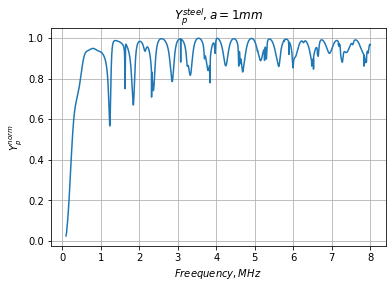

In [41]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$Freequency, MHz$')

plt.plot(f_array, Y_plane_array_steel_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('$Y_p^{steel}, a=1mm$')
plt.show()

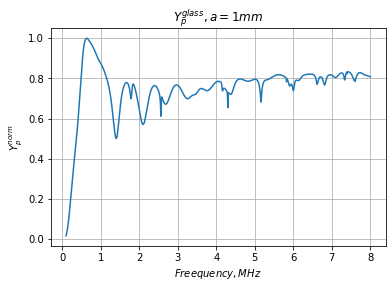

In [42]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$Freequency, MHz$')

plt.plot(f_array, Y_plane_array_glass_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('$Y_p^{glass}, a=1mm$')
plt.show()

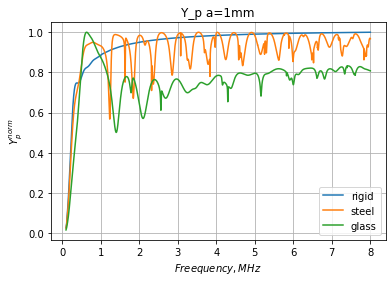

In [43]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$Freequency, MHz$')

plt.plot(f_array, Y_plane_array_norm, label='rigid')
plt.plot(f_array, Y_plane_array_steel_norm, label='steel')
plt.plot(f_array, Y_plane_array_glass_norm, label='glass')
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.legend()
plt.title('Y_p a=1mm')
plt.show()


In [67]:
array_ka = []
for elem in f_array:
    array_ka.append(2 * pi * elem * 10**6 * a / c_sound)

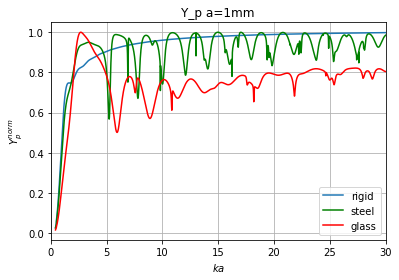

In [68]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(array_ka, Y_plane_array_norm, label='rigid')
plt.plot(array_ka, Y_plane_array_steel_norm, label='steel',  color='green')
plt.plot(array_ka, Y_plane_array_glass_norm, label='glass', color='red')
plt.xlim(0, 30)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.legend()
plt.title('Y_p a=1mm')
plt.show()

In [69]:
frame_Yp = pd.DataFrame({'ka': array_ka , 'Y_p_steel': Y_plane_array_steel_norm, 'Y_p_glass': Y_plane_array_glass_norm, 'Y_p_rigid': Y_plane_array_norm})
frame_Yp

,ka,Y_p_steel,Y_p_glass,Y_p_rigid
0,0.423110,0.024651,0.015572,0.027301
1,0.427341,0.025562,0.016144,0.028314
2,0.431572,0.026496,0.016730,0.029352
3,0.435803,0.027452,0.017329,0.030415
4,0.440035,0.028432,0.017943,0.031504
...,...,...,...,...
7895,33.827654,0.969505,0.807831,0.999992
7896,33.831885,0.969170,0.807820,0.999994
7897,33.836116,0.968779,0.807811,0.999996
7898,33.840348,0.968333,0.807804,0.999998


In [60]:
import openpyxl

In [70]:
frame_Yp.to_excel("output.xlsx",sheet_name='Sheet_name_1')